# Persistent Entropy and the Entropy Summary Function in TDA

Manuel Soriano-Trigueros - https://personal.us.es/msoriano4/

In [1]:
import numpy as np
import numpy.random as rd
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt
import random
rd.seed(1)

In this notebook, we will see how to use the variable "persistent entropy" (onwards PE)  and the curve "entropy summary function" (onwards ES) to compare barcodes using the Gudhi library. Besides, we will explain the intuition behind them and in which cases they can be useful.

Please, note that PE and ES are part of the [representations](https://gudhi.inria.fr/python/latest/representations.html) module of the Gudhi library. If you are interested on a specific tutorial about that module and how to use it to create a scikit-learn pipeline, please refer to [this notebook](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-representations.ipynb).

## Persistent Entropy

### What is PE?

Imagine you would like to use barcodes to perform a statistical analysis or a machine learning task. A common method is to calculate numerical variables from the barcodes and use them in your analysis. For example, you could count the number of bars appearing in the barcode. Not all variables are suitable for every situation. Usually, counting the number of bars has the advantage of having a clear interpretation in terms of the data, but it can be unstable respect to the input in many applications.

PE was first defined in its current form [here](https://link.springer.com/chapter/10.1007/978-3-319-29228-1_11), but a precursor of this definition appears in a previous [paper](https://www.sciencedirect.com/science/article/abs/pii/S0031320314002453).

#### Shannon entropy

In order to understand what is measuring PE, we need to introduce the Shannon entropy. Given a finite probability distribution, that is a set of numbers $\{p_i\}_{i=1\ldots,n}$ between $0$ and $1$ which satisfy $\sum_{i=1\ldots,n} p_i = 1$, its Shannon entropy is the value

$$
    S = \sum_{i=1\ldots,n} -p_i log(p_i).
$$

The Shannon entropy is symmetric, concave and its possible values range from $0$ to $\log(n)$. The maximum value $\log(n)$ is reached if and only if all $p_i$ have the same value, that is, $p_i = 1/n$.

#### The shannon index

An intuitive way of looking at the Shannon entropy is as a diversity index. Imagine that $\{p_i\}_{i=1\ldots,n}$ are the proportion of the species living in a ecosystem. In that case, $S$ is measuring the amount of diversity. For example, look at the following two ecosystems

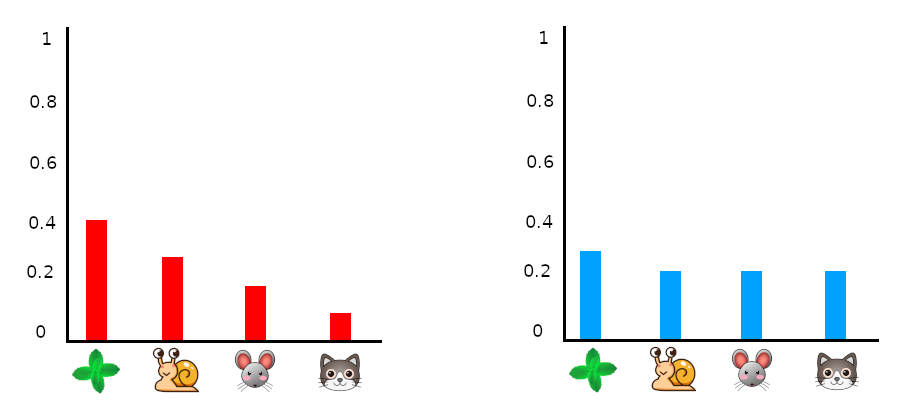

We expect the blue ecosystem to be more diverse than the red one, since the proportion of species is more balanced there. We also expect that the diversity increases when there are more species. This is exactly how $S$ work. The more species there are and the more balanced their proportion is, the greater $S$ is.

#### PE and barcodes

PE is just the Shannon entropy of the barcode. Consider the barcode $\{[a_i, b_i)\}_{i=1\ldots,n}$ and calculate its bars' length $l_i = b_i - a_i$ and the total length $L = \sum_{i=1\ldots,n} l_i $. Then,
denote $p_i = l_i/L$ is a finite probability distribution and

$$ PE = \sum_{i=1\ldots,n} -p_i log(p_i) $$

In the same way that the Shannon index, this value will be greater if there are many bars and their length is balanced. Note that it does not keep information about the birth or death of the bars.

### PE in Gudhi

We are using PE to finding differences between two family of point clouds: one following a normal distribution and the other following a uniform distribution.

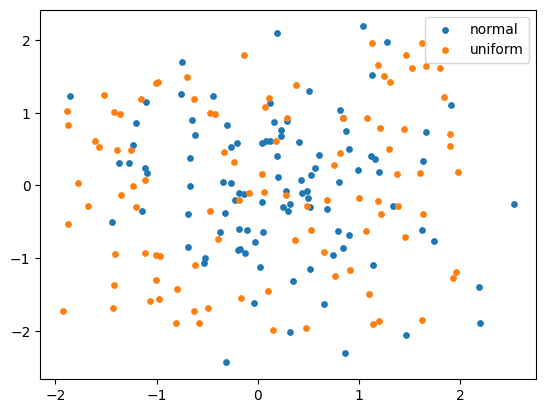

In [2]:
normal_pcs = []
uniform_pcs = []
for i in range(100):
    normal_pcs.append(rd.normal(size = [100,2]))
    uniform_pcs.append(rd.uniform(size = [100,2], low=-2, high=2))

#we show the first point cloud of each type as an example
fig, ax = plt.subplots()
normal_pc = normal_pcs[0]
uniform_pc = uniform_pcs[0]
ax.scatter(normal_pc[:,0], normal_pc[:,1], s=15, label = 'normal')
ax.scatter(uniform_pc[:,0], uniform_pc[:,1], s=15, label = 'uniform')
ax.legend()
#plt.show()

For each of these point clouds, we are calculating the 0th-dimensional persistent homology of its rips complex.

In [3]:
dgms_normal = []
for pc in normal_pcs:
    rips = gudhi.RipsComplex(points=pc).create_simplex_tree(max_dimension=1)
    rips.compute_persistence()
    dgms_normal.append(rips.persistence_intervals_in_dimension(0))
    
dgms_uniform = []
for pc in uniform_pcs:
    rips = gudhi.RipsComplex(points=pc).create_simplex_tree(max_dimension=1)
    rips.compute_persistence()
    dgms_uniform.append(rips.persistence_intervals_in_dimension(0))

Let's see two examples, the barcode of a normal point cloud and of a uniform point cloud

usetex mode requires TeX.


<AxesSubplot: title={'center': 'Persistence barcode'}>

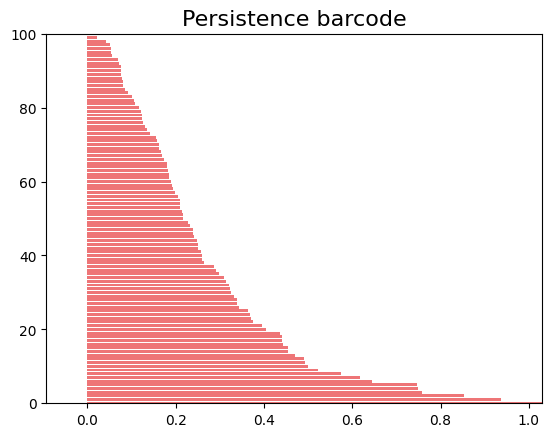

In [4]:
gd.plot_persistence_barcode(dgms_normal[0])

<AxesSubplot: title={'center': 'Persistence barcode'}>

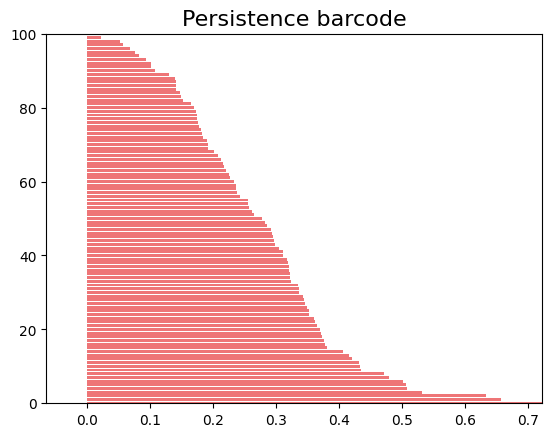

In [5]:
gd.plot_persistence_barcode(dgms_uniform[0])

In this example, we can see that there are actually differences between the two barcodes. The length of bars from the normal point cloud seems to have a greater variance. We are using PE to proving this fact.

Recall that in order to apply entropy, all bars in the barcode must be finite. A common way of proceed is to change infinity by a fixed value. Note that infinity bars does not contain information in the 0-th dimensional persistent homology of rips complexes, since every barcode has only one starting at 0. Then, in this case, we can remove the infinity bars without losing information.

In [6]:
# we create a lambda function which removes the infinity bars from a barcode.
remove_infinity = lambda barcode : np.array([bars for bars in barcode if bars[1]!= np.inf])
# apply this operator to all barcodes.
dgms_normal = list(map(remove_infinity, dgms_normal))
dgms_uniform = list(map(remove_infinity, dgms_uniform))

Once all bars in our barcodes are finite, we can apply PE. We use the [representations.Entropy](http://gudhi.gforge.inria.fr/python/latest/representations.html#gudhi.representations.vector_methods.Entropy) method. When applied to a list of barcodes, it gives another list with their respective persistent entropys.

In [7]:
PE = gd.representations.Entropy()
pe_normal = PE.fit_transform(dgms_normal)
pe_normal[:9]

array([[4.37779285],
       [4.46314427],
       [4.37882067],
       [4.39868606],
       [4.34488209],
       [4.43111221],
       [4.3277631 ],
       [4.42686533],
       [4.32486701]])

In [8]:
pe_uniform = PE.fit_transform(dgms_uniform)
pe_uniform[:9]

array([[4.48622121],
       [4.44512338],
       [4.47480549],
       [4.42726623],
       [4.4749265 ],
       [4.48355902],
       [4.47668513],
       [4.48049865],
       [4.45978629]])

Let's show the differences using [boxplots](https://en.wikipedia.org/wiki/Box_plot). In order to do that, we need to transform these two ndarrays into two arrays of numbers.

In [9]:
pe_normal_array = np.array(pe_normal[:,0])
pe_uniform_array = np.array(pe_uniform[:,0])

Using the boxplot function from the matplotlib library we obtain the following graphic,

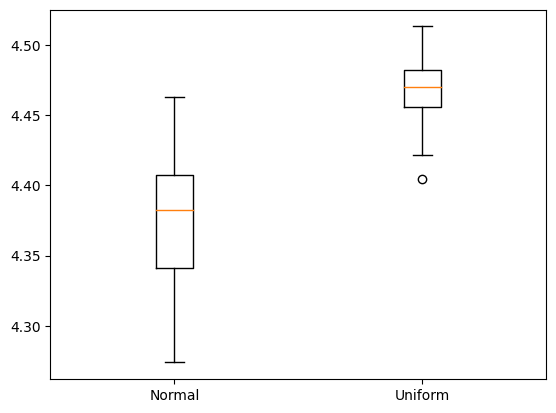

In [10]:
fig, ax = plt.subplots()

#Fix the boxplot
bp = ax.boxplot([pe_normal_array, pe_uniform_array], labels=['Normal', 'Uniform'])

#We change the axis letter size to see them better
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=15)

plt.show()

There is a clear difference between the PE of the uniform point clouds and the normal point clouds. Note that, in this experiment, all barcodes have the same number of bars. Then, we can conclude that connected components from uniform point clouds tend to have a more homogeneous length than the ones from the normal point cloud. It makes sense, doesn't it?

Now we know how to calculate PE using Gudhi. You can use it as a parameter in your scikit-learn pipeline or as a variable in a statistical test.

### When should I use PE?

There are plenty of different methods you can use to compare barcodes. Depending on the situation, ones might be more convenient than others. Then, when shall we use PE?

A first remark, is that PE does not keep the moment of birth and death of the bars. Then, if this information is important for your analysis it should not be used. As we will see, the ES function solves this problem.

Fix two barcodes $B_1$ and $B_2$ with persistent entropy $PE_1$ and $PE_2$. In this [paper](https://arxiv.org/abs/1803.08304), a bound for $|PE_1 - PE_2|$ in terms of the bottleneck distance was proven. It can be deduced that, when dealing with  a collection of barcodes $\{ B_i \}$, PE tends to be unstable if the number of bars in each barcode is very different from one to others. Actually, in that situation, PE is highly correlated with counting the number of bars. Another cause of instability may be the lack of a lower bound on the total length of the barcodes (in other words, the sum of their bars).

Then, PE should be used when:
- The number of bars is similar between all barcodes    
- There exists a lower bound for the sum of all bars in each barcode.

In particular, PE is ideal for analyzing 0th-dimensional barcodes coming from alpha/Vietoris-Rips complexes when all point clouds have the same number of points. In this situation, there is a good interpretation of what is measuring persistent entropy. Please, refer to Proposition 6 appearing in this [paper](https://www.mdpi.com/2227-7390/9/15/1723).

# The Entropy Summary Function

## What is the ES function

As we said, PE has the disadvantage that it does not keep information about the birth and death time of the bars. This also happens, for example, when counting the number of bars. In that case, a possible solution is to create a function which count the numbers of bars which are alive at each moment. It is known as the Betti curve and, given a barcode $B = \{[a_i, b_i)\}_{i=1\ldots,n}$, its mathematical definition is the following:

$$ \beta(t) = \sum_{i=1\ldots,n} \delta_i(t) $$ where $\delta_i(t)$ is $1$ if $t \in [a_i, b_i)$ and $0$ otherwise.

The ES function is constructed based on the same idea. Instead of calculating the entropy of the whole diagram, we only consider the ones which are alive in a concrete moment. Its mathematical expression is the following:

$$ ES(t) = \sum_{i=1\ldots,n} p_i\log(p_i)\delta_i(t). $$

## Using the ES function in Gudhi

In order to see some examples, lets generate the 1-dimensional barcodes from the previous point clouds.

In [11]:
dgms_normal = []
for pc in normal_pcs:
    rips = gudhi.RipsComplex(points=pc).create_simplex_tree(max_dimension=2)
    rips.persistence()
    dgms_normal.append(rips.persistence_intervals_in_dimension(1))
    
dgms_uniform = []
for pc in uniform_pcs:
    rips = gudhi.RipsComplex(points=pc).create_simplex_tree(max_dimension=2)
    rips.persistence()
    dgms_uniform.append(rips.persistence_intervals_in_dimension(1))

<AxesSubplot: title={'center': 'Persistence barcode'}>

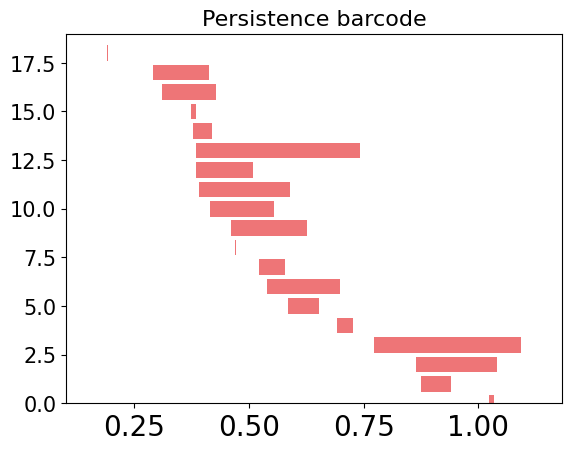

In [12]:
#An example of 1 dimensional barcode
gd.plot_persistence_barcode(dgms_normal[0])

We can calculate the Betti curves of these barcodes using the [representations.BettiCurve](http://gudhi.gforge.inria.fr/python/latest/representations.html#gudhi.representations.vector_methods.BettiCurve) method. When applied to a list of barcodes, it gives another list with their respective Betti curves.

In [13]:
# Sample range is the interval where the Betti curve is calculated. It is an optional parameter
BC = gd.representations.BettiCurve(sample_range=[0,1.5], resolution = 150)
bc_normal = BC.fit_transform(dgms_normal)
bc_uniform = BC.fit_transform(dgms_uniform)

For example, the Betti curve of the upper diagram is the following

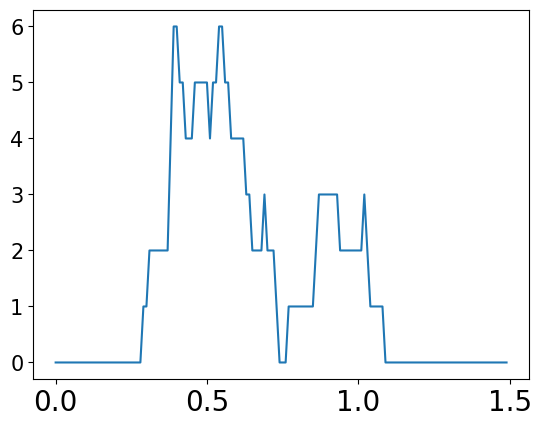

In [14]:
xseq = np.array(range(0,150))/100
plt.plot(xseq, bc_normal[0])

We proceed similarly to calculate the ES function. We use the [representations.Entropy](http://gudhi.gforge.inria.fr/python/latest/representations.html#gudhi.representations.vector_methods.Entropy) method. This time, we include the parameter mode='vector' to specify we do not want to calculate PE but ES. Using a list of barcodes as an input, we obtain a list of curves, each of which being the corresponding ES function. You can use the parameter sample_range to specify the domain of the function and resolution to specify the number of samples you use to calculate it. The normalized parameter indicates if you want to normalize the ES function by its L1 norm (it is done by default). It is used when you want your function to be independent of the coordinates used to generate the persistence barcode.

In [15]:
ES = gd.representations.Entropy(mode='vector', sample_range=[0,1.5], resolution = 151, normalized = False)
es_normal = ES.fit_transform(dgms_normal)
es_uniform = ES.fit_transform(dgms_uniform)

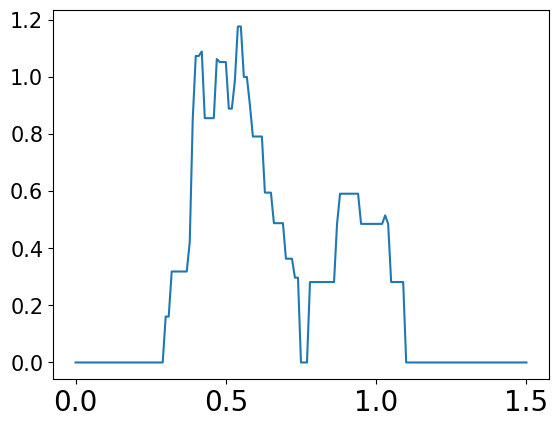

In [16]:
xseq = np.array(range(0,151))/100
plt.plot(xseq, es_normal[0])

The ES function is usually quite similar to the Betti curve although it can be completely different for others. 

### Stability of the ES-function

The main theoretical advantage of the ES function respect to the Betti curve is that it is more robust to modifications in the input. Actually, the following result holds:

$$ |ES_1 - ES_2| \le d_\infty(B_1, B_2)\left(\log(n_{\infty})-\dfrac{3}{2}\log\left(\dfrac{3}{2}\dfrac{n_\infty}{L_\max}d_\infty( B_1,B_2 )\right)\right) $$

where $ES_1$ and $ES_2$ are the ES function of the barcodes $B_1$ and $B_2$, $L_\max$ is the maximum total length of the bars in the barcodes, $d_\infty$ is the bottleneck distance and $n_\infty$ is the sum of the numbers of unpaired bars and the number of pairs given by $d_\infty$. This formula can be directly deduce from the one appearing [here](https://arxiv.org/abs/1803.08304).

As you might notice, the source of unstability might be $L_\max$ and $n_\infty$. Nevertheless, in opposition to what happened with PE, these terms are inside a logarithm, making it much more robust to noise. This is an advantage with respect to, for example, the Betti curve.

### When should I use the ES function?

Usually, the ES function can be used in the same fashion than the Betti curve. If you expect noise to introduce artificial small bars in the barcodes, then you should use the ES function instead. When the barcodes have some bars which are considerably bigger in comparison with the others, the ES function and the Betti curve tends to produce different values. In that cases, both curves can complement each other. Please, refer to this [paper](https://arxiv.org/abs/1904.07768) to a more general study of persistence curves, including the Betti curve and the ES function (denoted there as life entropy).

Recall you can use the ES function as a parameter in your scikit-learn pipeline, together with other methods from the [representations](https://gudhi.inria.fr/python/3.1.0.rc1/representations.html) module.